In [238]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [239]:
# Carga de todos los csv en la carpeta 'mediciones'
files = os.listdir('mediciones')

# Lista de dataframes
dfs = [pd.read_csv('mediciones/' + file) for file in files]

# Nombre de las futuras columnas
columns = [f.replace(".csv", "") for f in files ]


In [240]:
# Verifico que todos los dataframes tengan la misma columna de tiempo
time_cols = [df['time'].tolist() for df in dfs]
for i, time_col in enumerate(time_cols):
    if time_col != time_cols[0]:
        print(f'Dataframe {i} es diferente!')
        break
    else:
        print(f'Df {i} vs 0: Todas las filas son iguales')

Df 0 vs 0: Todas las filas son iguales
Df 1 vs 0: Todas las filas son iguales
Df 2 vs 0: Todas las filas son iguales
Df 3 vs 0: Todas las filas son iguales
Df 4 vs 0: Todas las filas son iguales
Df 5 vs 0: Todas las filas son iguales
Df 6 vs 0: Todas las filas son iguales
Df 7 vs 0: Todas las filas son iguales


In [241]:
# Concateno todos los dataframes sobre una única columna time
df = pd.concat([df['(V)'] for df in dfs], axis=1)
df.columns = columns
df['time'] = time_cols[0]

# Convierto la columna time en indice
df.set_index('time', inplace=True)

# Reordeno columnas usando parte numerica del nombre
columns = sorted(columns, key=lambda x: int(x[:-2]))
df = df[columns]

df.head()

,181mm,261mm,552mm,644mm,743mm,839mm,927mm,1042mm
time,,,,,,,,
0.000,0.355050,0.347517,0.357561,0.360072,0.360072,0.360072,0.357561,0.355050
0.005,0.355050,0.355050,0.365094,0.357561,0.367605,0.360072,0.357561,0.357561
0.010,0.355050,0.347517,0.355050,0.367605,0.365094,0.362583,0.357561,0.357561
0.015,0.357561,0.339984,0.357561,0.362583,0.357561,0.357561,0.350028,0.357561
0.020,0.347517,0.355050,0.357561,0.362583,0.355050,0.360072,0.365094,0.357561


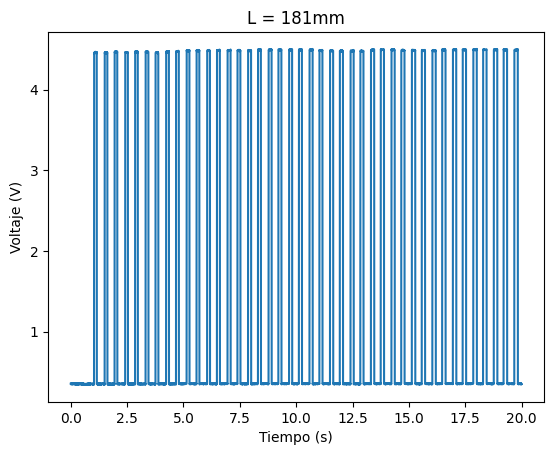

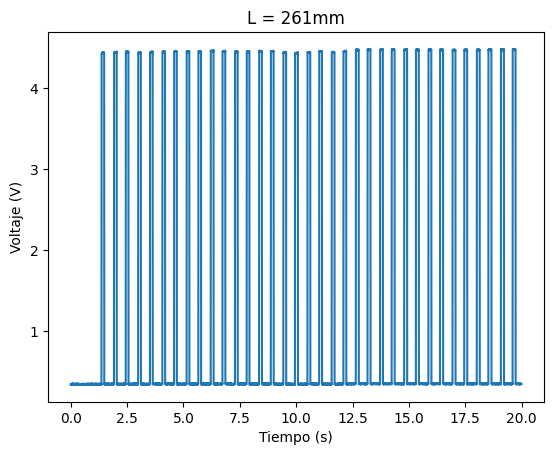

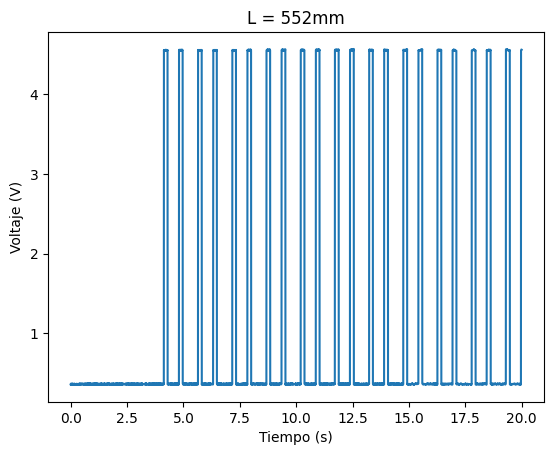

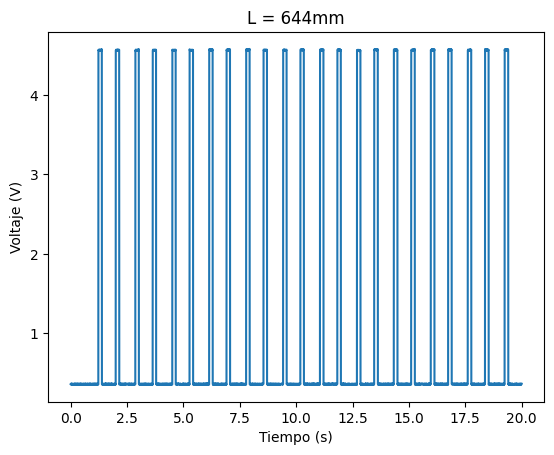

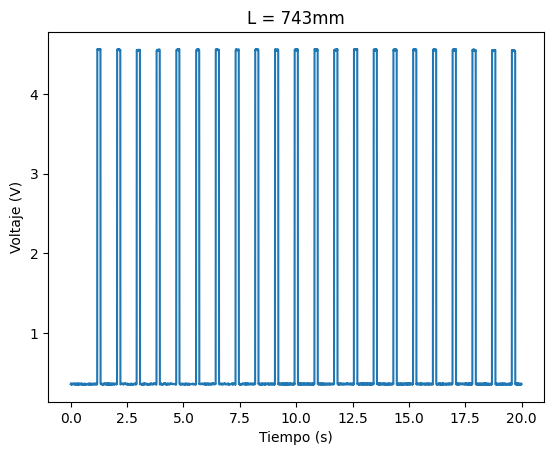

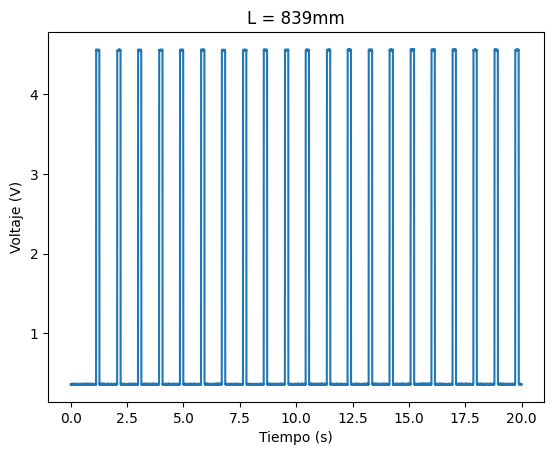

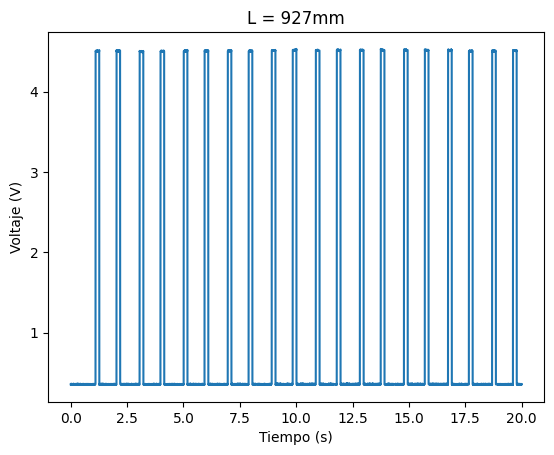

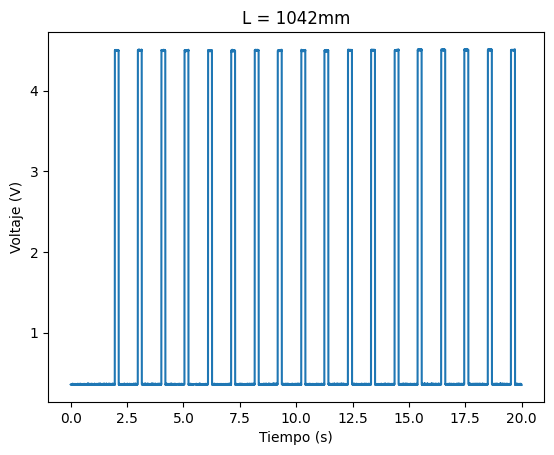

In [242]:
# Grafico todas las señales
for c in columns:
    df[c].plot()
    plt.title(f"L = {c}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.show()

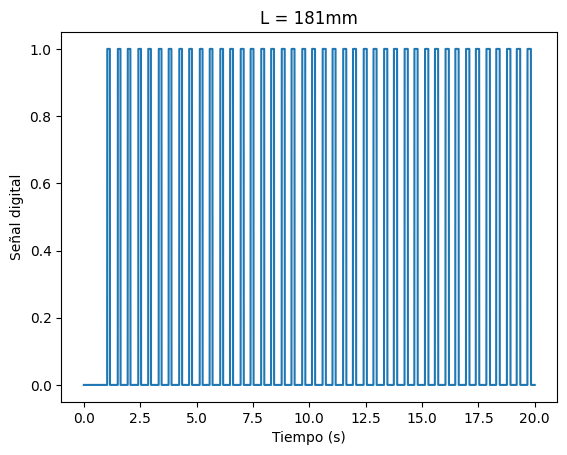

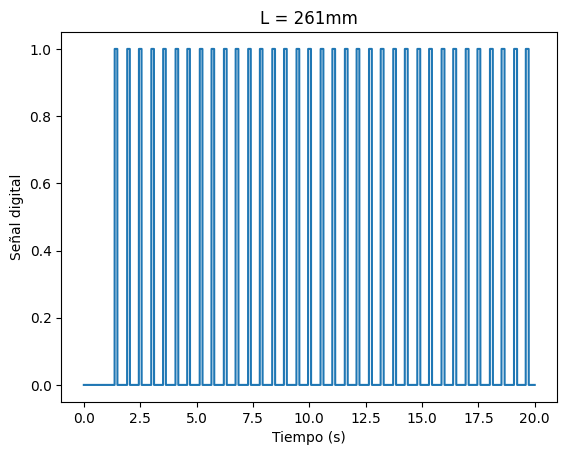

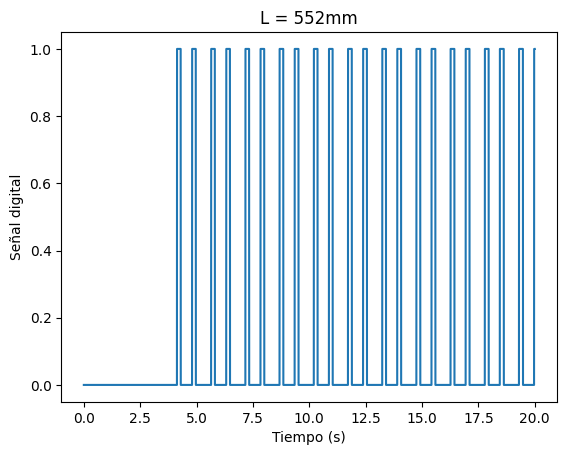

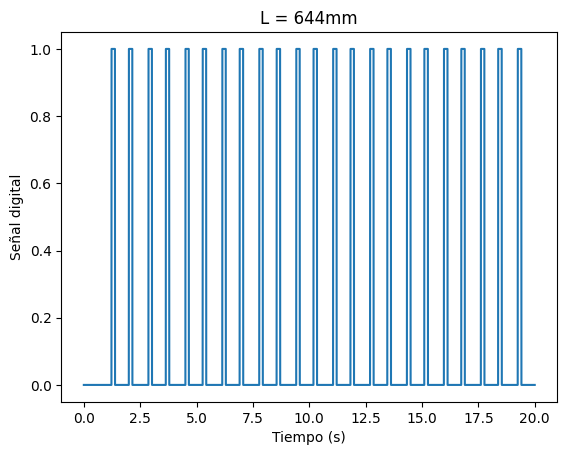

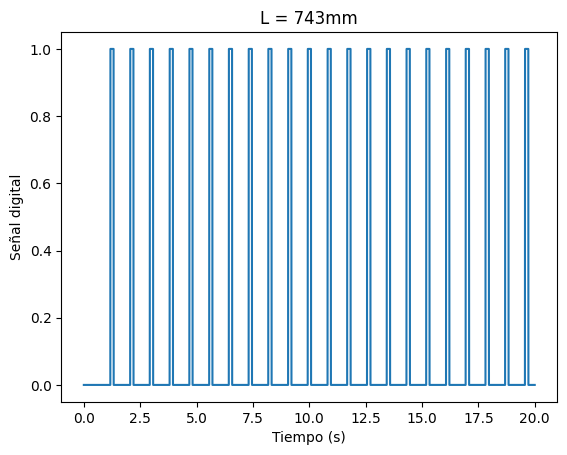

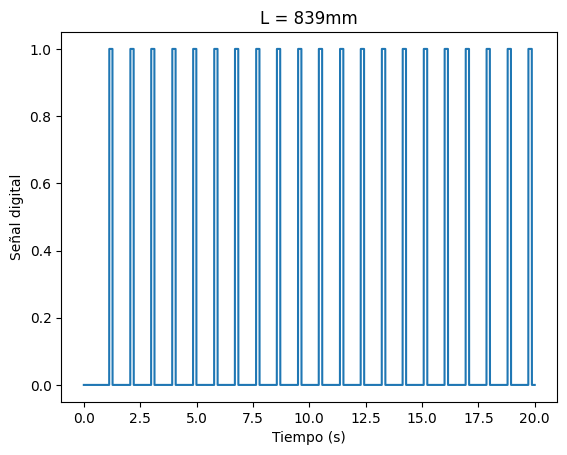

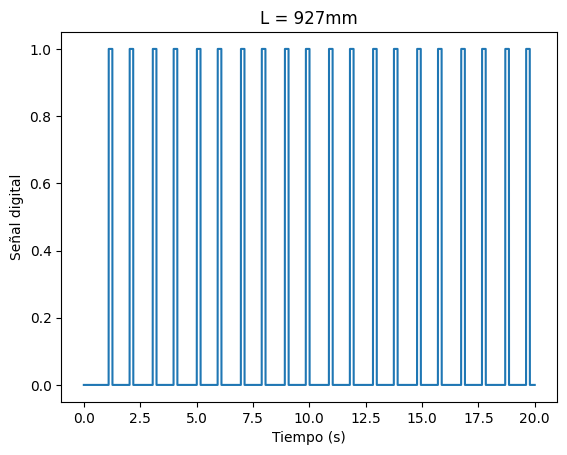

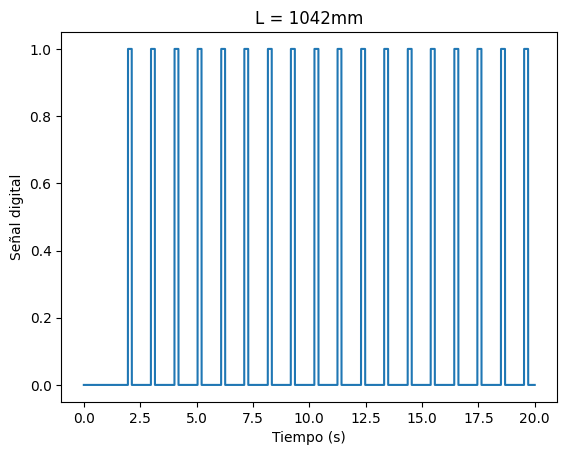

In [243]:
# Duplico y digitalizo cada columna: Si V es mayor a 3, entonces 1, sino 0
df_digital = df.apply(lambda x: x > 3).astype(int)

# Señales digitales
for c in columns:
    df_digital[c].plot()
    plt.title(f"L = {c}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Señal digital")
    plt.show()


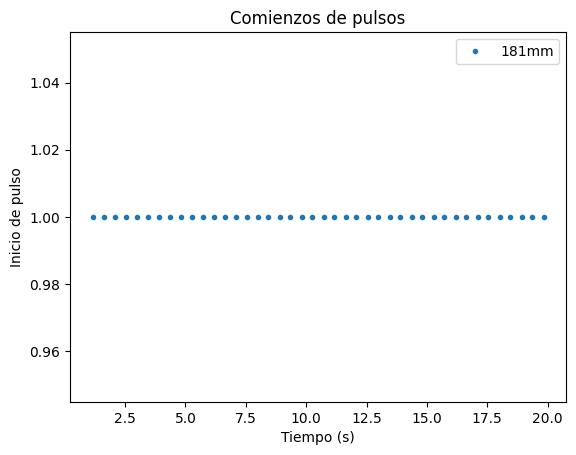

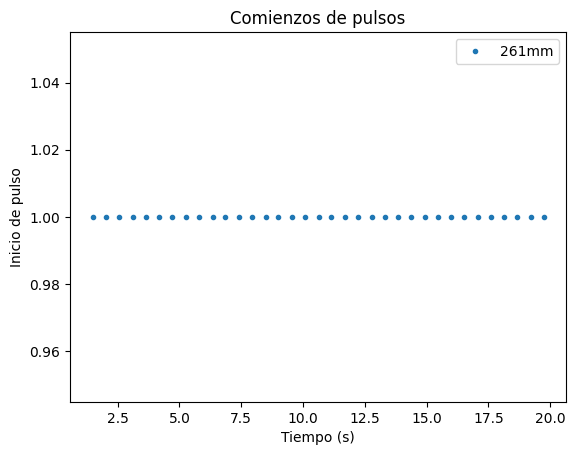

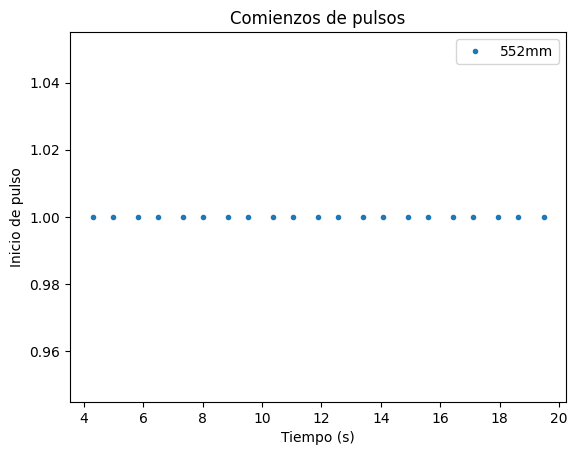

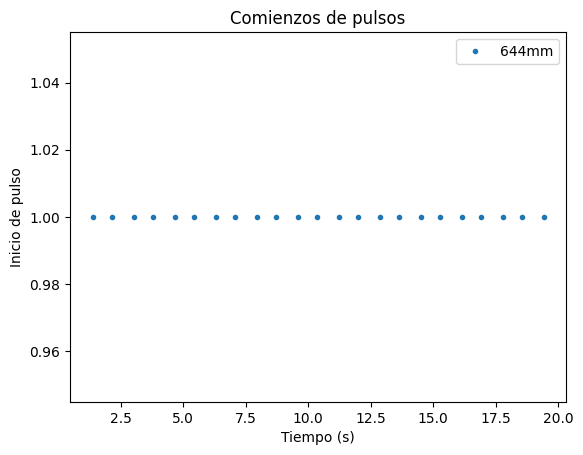

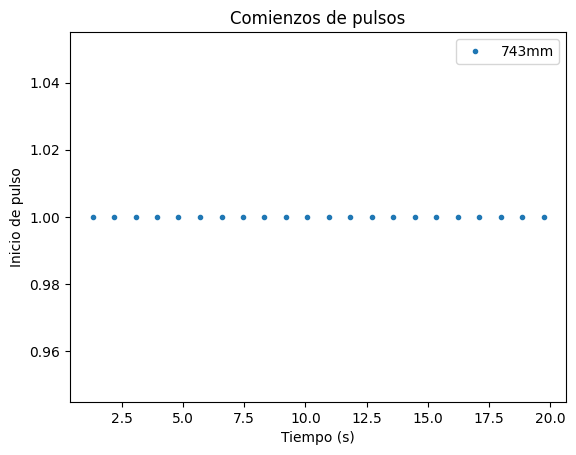

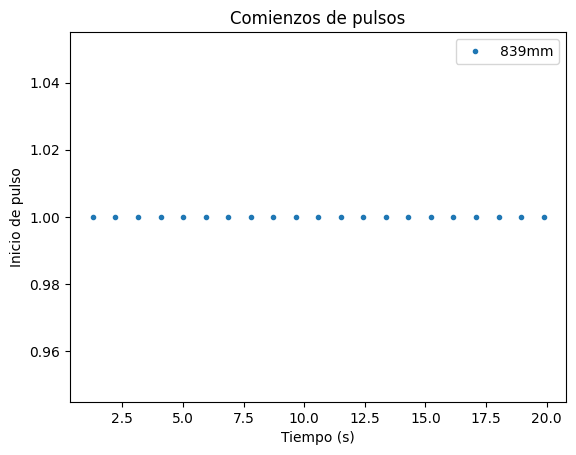

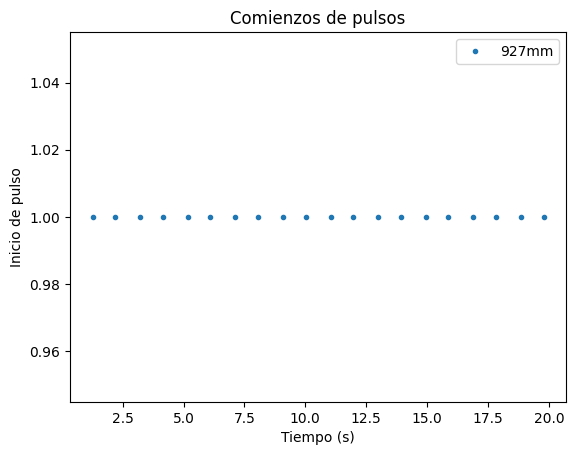

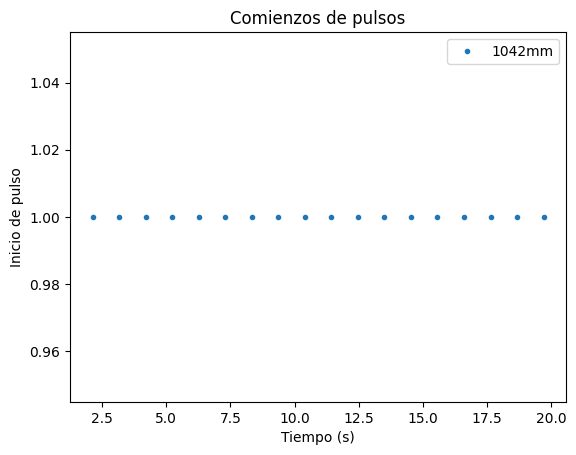

In [244]:
# Creo lista de dataframes solo con los comienzos de cada pulso
starts_dfs = [df_digital[c].diff().apply(lambda x: x == -1).astype(int) for c in columns]

# Borro filas con zeros de cada df
starts_dfs = [df[df == 1].dropna() for df in starts_dfs]

for s in starts_dfs:
    s.plot(style='.')
    plt.title("Comienzos de pulsos")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Inicio de pulso")
    plt.legend()
    plt.show()

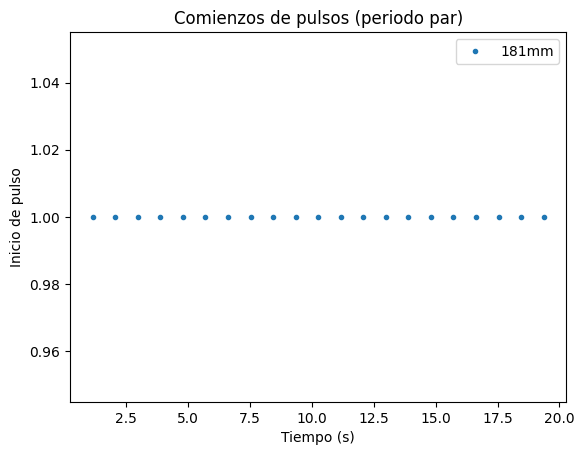

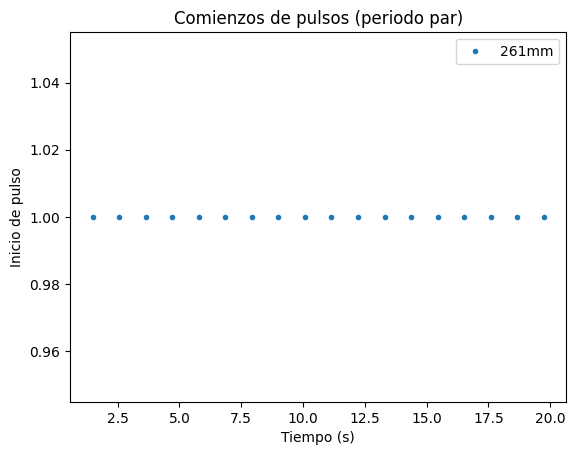

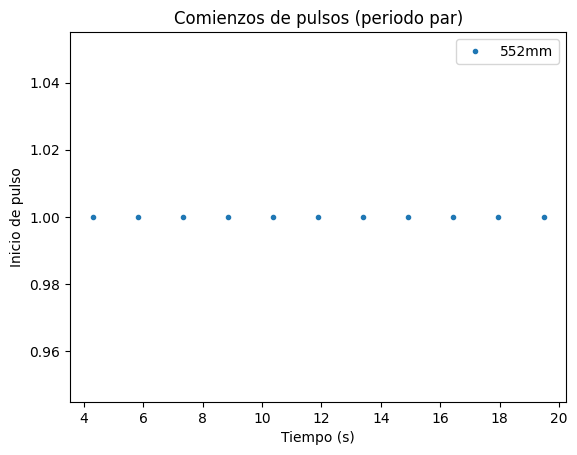

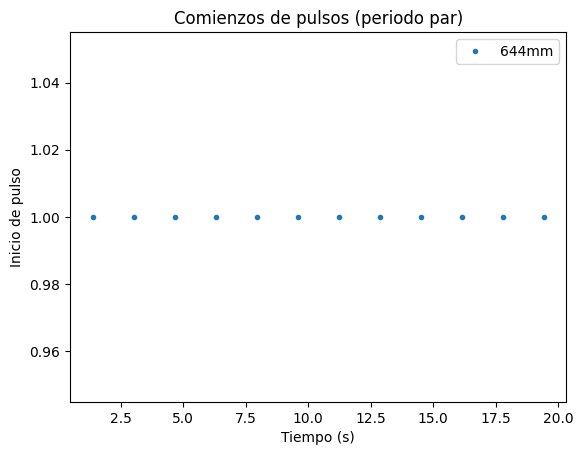

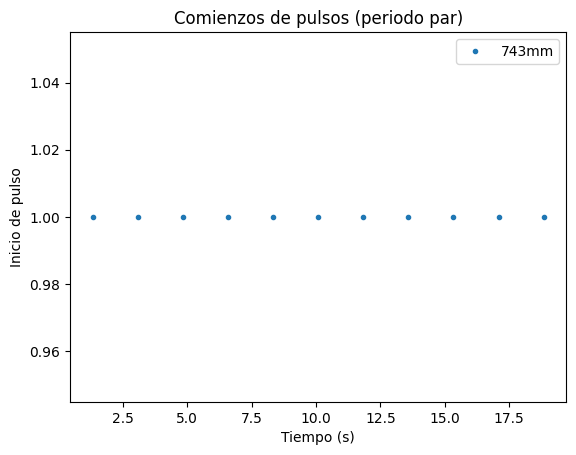

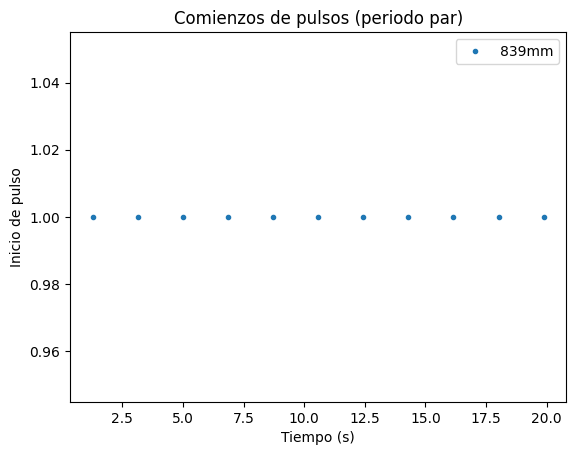

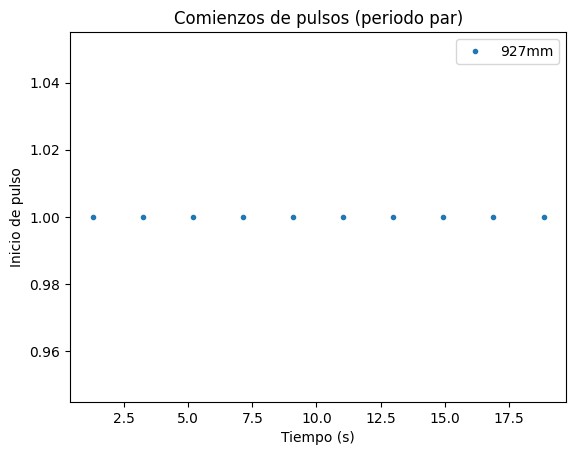

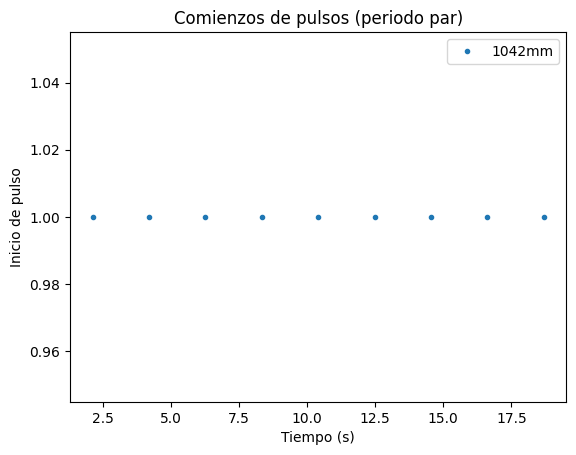

In [245]:
# Separo filas pares e impares
even_period_dfs = [df.iloc[::2] for df in starts_dfs]
odd_period_dfs = [df.iloc[1::2] for df in starts_dfs]


for p in even_period_dfs:
    p.plot(style='.')
    plt.title("Comienzos de pulsos (periodo par)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Inicio de pulso")
    plt.legend()

    plt.show()

In [246]:
# Convierto index como columna de tiempo
even_period_dfs = [df.reset_index(inplace=False) for df in even_period_dfs]
odd_period_dfs = [df.reset_index(inplace=False) for df in odd_period_dfs]


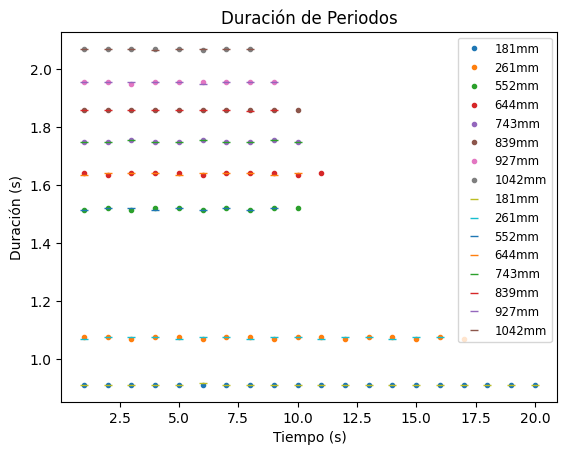

In [247]:
for i in range(len(even_period_dfs)):
    even_period_dfs[i]['time'].diff().plot(style='.')

for i in range(len(odd_period_dfs)):
    odd_period_dfs[i]['time'].diff().plot(style='_')

plt.title("Duración de Periodos")
plt.xlabel("Tiempo (s)")
plt.ylabel("Duración (s)")
plt.legend(columns+columns, fontsize='small')
plt.show()

In [248]:
def get_values(even_df, odd_df):
    return list(even_df['time'].diff().dropna().values) + list(odd_df['time'].diff().dropna().values)

In [249]:
duraciones = [get_values(even_df, odd_df) for even_df, odd_df in zip(even_period_dfs, odd_period_dfs)]

period_means = [np.mean(d) for d in duraciones]
period_stds = [np.std(d) for d in duraciones]
period_amounts = [len(d) for d in duraciones]

g_real = 9.79687

errores = []
longitudes = []
periodos = []
periodos_ideales = []
for c, T_est, s, a in zip(columns, period_means, period_stds, period_amounts):
    print(f"L = {c} - {a} mediciones")
    print(f"Periodo medio:   {T_est:.6f}")
    print(f"Desvio estandar: {s:.6f}")
    L = float(c.replace("mm", "")) / 1000
    T_ideal = 2 * np.pi * np.sqrt(L / g_real)
    # Local gravity https://www.sensorsone.com/local-gravity-calculator/#local-gravity
    print(f"Periodo esperado: {T_ideal:.6f}")
    print(f"Error: {abs(T_ideal - T_est):.6f}")
    print(f"Error: {abs(T_ideal - T_est) / T_ideal * 100:.6f}%")
    errores.append(abs(T_ideal - T_est))
    longitudes.append(L)
    periodos.append(T_est)
    periodos_ideales.append(T_ideal)
    print("-"*50)


L = 181mm - 40 mediciones
Periodo medio:   0.910125
Desvio estandar: 0.000781
Periodo esperado: 0.854035
Error: 0.056090
Error: 6.567692%
--------------------------------------------------
L = 261mm - 33 mediciones
Periodo medio:   1.073333
Desvio estandar: 0.002357
Periodo esperado: 1.025549
Error: 0.047784
Error: 4.659382%
--------------------------------------------------
L = 552mm - 19 mediciones
Periodo medio:   1.517895
Desvio estandar: 0.002469
Periodo esperado: 1.491440
Error: 0.026455
Error: 1.773784%
--------------------------------------------------
L = 644mm - 21 mediciones
Periodo medio:   1.638571
Desvio estandar: 0.002259
Periodo esperado: 1.610939
Error: 0.027632
Error: 1.715292%
--------------------------------------------------
L = 743mm - 20 mediciones
Periodo medio:   1.751500
Desvio estandar: 0.002291
Periodo esperado: 1.730337
Error: 0.021163
Error: 1.223078%
--------------------------------------------------
L = 839mm - 19 mediciones
Periodo medio:   1.859737
Des

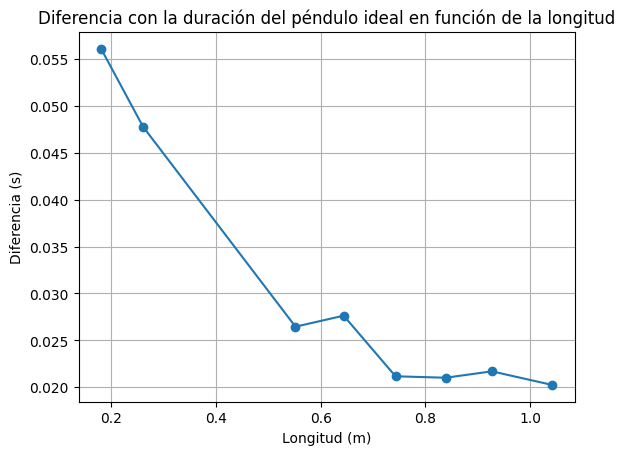

In [250]:
plt.plot(longitudes, errores, '-o')
plt.xlabel("Longitud (m)")
plt.ylabel("Diferencia (s)")
plt.title("Diferencia con la duración del péndulo ideal en función de la longitud")
plt.grid()
# Add vertical line and xtick in x axis at each x point value
#plt.xticks(longitudes)

plt.show()

In [251]:
import numpy as np


def deltaT(desv, n):
    return np.sqrt((1 / 200) ** 2 + (desv / np.sqrt(n)) ** 2)


def errorT(dT, T):
    return (2 * dT) / T


def errorL(L):  # no considera errores estadísticos
    return 0.001 / L


def mayorError():
    res = []
    erroresRelativosT = []
    erroresRelativosL = []
    for c, T, s, n, L in zip(
        columns, period_means, period_stds, period_amounts, longitudes
    ):
        dT = deltaT(s, n)
        errorRelativoT = errorT(dT, T)
        errorRelativoL = errorL(L)
        if errorRelativoT > errorRelativoL:
            res.append("T")
        else:
            res.append("L")
        erroresRelativosT.append(errorRelativoT)
        erroresRelativosL.append(errorRelativoL)
    return (res, erroresRelativosT, erroresRelativosL)


res, erroresRelativosT, erroresRelativosL = mayorError()

print(erroresRelativosT)

print(erroresRelativosL)

print(res)

[0.010990848961372349, 0.009348087149222896, 0.006630199447606313, 0.006132459779457068, 0.005739287985328101, 0.005384155769909651, 0.005130561444260335, 0.004848865707641902]
[0.005524861878453039, 0.0038314176245210726, 0.0018115942028985505, 0.0015527950310559005, 0.0013458950201884253, 0.001191895113230036, 0.0010787486515641855, 0.0009596928982725527]
['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T']


## Ajustes Lineales

m = 1.3445 +- 1.2350
b = 0.7248 +- 0.8756
R2 = 0.9895


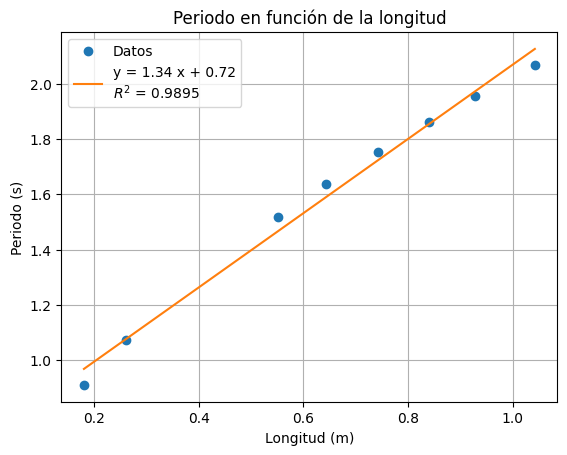

In [252]:
from scipy.optimize import curve_fit

def lineal(x, m, b):
    return m * x + b

popt, pcov = curve_fit(lineal, longitudes, periodos, absolute_sigma=True)

m, b = popt
dm, db = np.sqrt(np.diag(pcov))

R2 = 1 - np.sum((lineal(np.array(longitudes), m, b) - periodos)**2) / np.sum((periodos - np.mean(periodos))**2)

print(f"m = {m:.4f} +- {dm:.4f}")
print(f"b = {b:.4f} +- {db:.4f}")
print(f"R2 = {R2:.4f}")

plt.plot(longitudes, periodos, 'o', label='Datos')
plt.plot(longitudes, lineal(np.array(longitudes), m, b), label=f"y = {m:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel("Longitud (m)")
plt.ylabel("Periodo (s)")
plt.title("Periodo en función de la longitud")
plt.legend()
plt.grid()
plt.show()

m = 1.9450 +- 1.7772
b = 0.0790 +- 1.4313
R2 = 0.9999


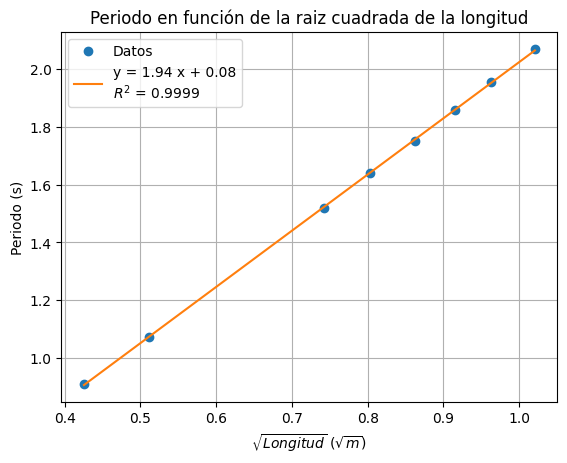

In [253]:
popt, pcov = curve_fit(lineal, np.sqrt(longitudes), periodos, absolute_sigma=True)

m, b = popt
dm, db = np.sqrt(np.diag(pcov))

R2 = 1 - np.sum((lineal(np.array(np.sqrt(longitudes)), m, b) - periodos)**2) / np.sum((periodos - np.mean(periodos))**2)

print(f"m = {m:.4f} +- {dm:.4f}")
print(f"b = {b:.4f} +- {db:.4f}")
print(f"R2 = {R2:.4f}")

plt.plot(np.sqrt(longitudes), periodos, 'o', label='Datos')
plt.plot(np.sqrt(longitudes), lineal(np.array(np.sqrt(longitudes)), m, b), label=f"y = {m:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")
plt.xlabel(r"$\sqrt{ {Longitud}}$ ($\sqrt{m}$)")
plt.ylabel("Periodo (s)")
plt.title("Periodo en función de la raiz cuadrada de la longitud")
plt.legend()
plt.grid()
plt.show()

m = 1.9450 +- 1.7772
b = 0.0790 +- 1.4313
R2 = 0.9999


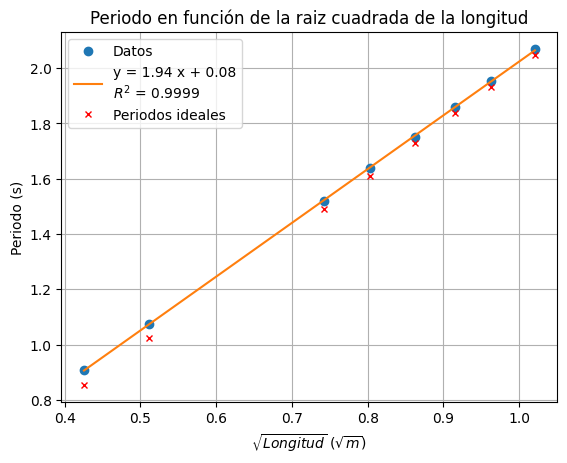

In [254]:
popt, pcov = curve_fit(lineal, np.sqrt(longitudes), periodos, absolute_sigma=True)

m, b = popt
dm, db = np.sqrt(np.diag(pcov))

R2 = 1 - np.sum((lineal(np.array(np.sqrt(longitudes)), m, b) - periodos)**2) / np.sum((periodos - np.mean(periodos))**2)

print(f"m = {m:.4f} +- {dm:.4f}")
print(f"b = {b:.4f} +- {db:.4f}")
print(f"R2 = {R2:.4f}")

plt.plot(np.sqrt(longitudes), periodos, 'o', label='Datos')
plt.plot(np.sqrt(longitudes), lineal(np.array(np.sqrt(longitudes)), m, b), label=f"y = {m:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")
plt.plot(np.sqrt(longitudes), periodos_ideales, marker='x', markersize=5, linestyle="", label='Periodos ideales', color='red')
plt.xlabel(r"$\sqrt{ {Longitud}}$ ($\sqrt{m}$)")
plt.ylabel("Periodo (s)")
plt.title("Periodo en función de la raiz cuadrada de la longitud")
plt.legend()
plt.grid()
plt.show()

In [255]:
T2 = np.array(periodos)**2
popt, pcov = curve_fit(lineal, longitudes, T2, absolute_sigma=True)

m, b = popt
dm, db = np.sqrt(np.diag(pcov))

R2 = 1 - np.sum((lineal(np.array(longitudes), m, b) - T2)**2) / np.sum((T2 - np.mean(T2))**2)
R2 = 1 - np.sum((lineal(np.array(longitudes), m, b) - periodos)**2) / np.sum((periodos - np.mean(periodos))**2)


print(f"m = {m:.4f} +- {dm:.4f}")
print(f"b = {b:.4f} +- {db:.4f}")
print(f"R2 = {R2:.4f}")

plt.plot(longitudes, T2, 'o', label='Datos')
plt.plot(longitudes, lineal(longitudes, m, b), label=f"y = {m:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")
plt.xlabel("Longitud (m)")
plt.ylabel(r"$Periodo^2$ ($s^2$)")
plt.title("Periodo^2 en función de la longitud")
plt.legend()
plt.grid()
plt.show()



TypeError: can't multiply sequence by non-int of type 'numpy.float64'

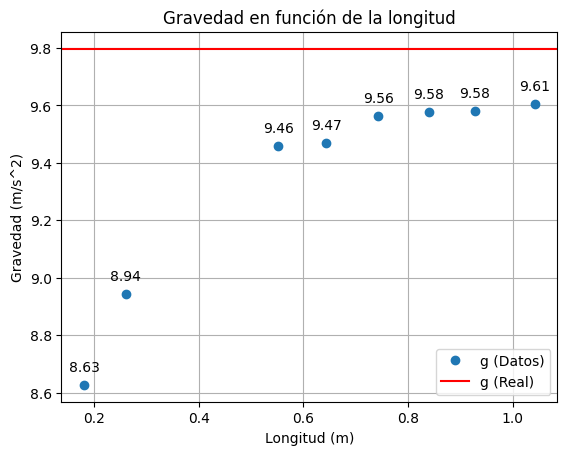

In [ ]:
# g = (2*np.pi / T)^2 * L

g_est = (2*np.pi / np.array(periodos))**2 * np.array(longitudes)

plt.plot(longitudes, g_est, 'o', label='g (Datos)')
plt.axhline(y=g_real, color='r', linestyle='-', label='g (Real)')

for i, g in enumerate(g_est):
    txt = f"{g:.2f}"
    plt.annotate(txt, (longitudes[i], g_est[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Longitud (m)")
plt.ylabel("Gravedad (m/s^2)")
plt.title("Gravedad en función de la longitud")
plt.legend()
plt.grid()
plt.show()
